In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [51]:
df = pd.read_csv('../../dataset/MLTempDataset.csv')
df.drop(columns=['Unnamed: 0', 'Datetime1'], inplace= True)
df

,DAYTON_MW,Datetime
0,20.867,2022-01-04 00:00:00
1,21.000,2022-01-04 01:00:00
2,20.867,2022-01-04 02:00:00
3,20.650,2022-01-04 03:00:00
4,20.400,2022-01-04 04:00:00
...,...,...
6671,27.350,2022-10-08 23:00:00
6672,26.800,2022-10-09 00:00:00
6673,26.450,2022-10-09 01:00:00
6674,25.900,2022-10-09 02:00:00


# Exploratory Analysis

In [52]:
# Analysis of the temperature column
df['DAYTON_MW'].describe()

count    6676.000000
mean       21.736007
std         6.850502
min         5.350000
25%        17.512750
50%        23.900000
75%        26.367000
max        36.500000
Name: DAYTON_MW, dtype: float64

In [53]:
# Make sure your "Date" column is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])
 
# Sorting the data by date (if not sorted)
df = df.sort_values(by='Datetime')

In [54]:
df_arima = df.copy()
# Resetting the index
df_arima.set_index('Datetime', inplace=True)
 
df_arima.dropna(inplace=True)
df_arima

,DAYTON_MW
Datetime,
2022-01-04 00:00:00,20.867
2022-01-04 01:00:00,21.000
2022-01-04 02:00:00,20.867
2022-01-04 03:00:00,20.650
2022-01-04 04:00:00,20.400
...,...
2022-10-08 23:00:00,27.350
2022-10-09 00:00:00,26.800
2022-10-09 01:00:00,26.450


In [56]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = pd.to_datetime(df['Datetime'])
df_prophet['y'] = df['DAYTON_MW']
df_prophet

,ds,y
0,2022-01-04 00:00:00,20.867
1,2022-01-04 01:00:00,21.000
2,2022-01-04 02:00:00,20.867
3,2022-01-04 03:00:00,20.650
4,2022-01-04 04:00:00,20.400
...,...,...
6671,2022-10-08 23:00:00,27.350
6672,2022-10-09 00:00:00,26.800
6673,2022-10-09 01:00:00,26.450
6674,2022-10-09 02:00:00,25.900


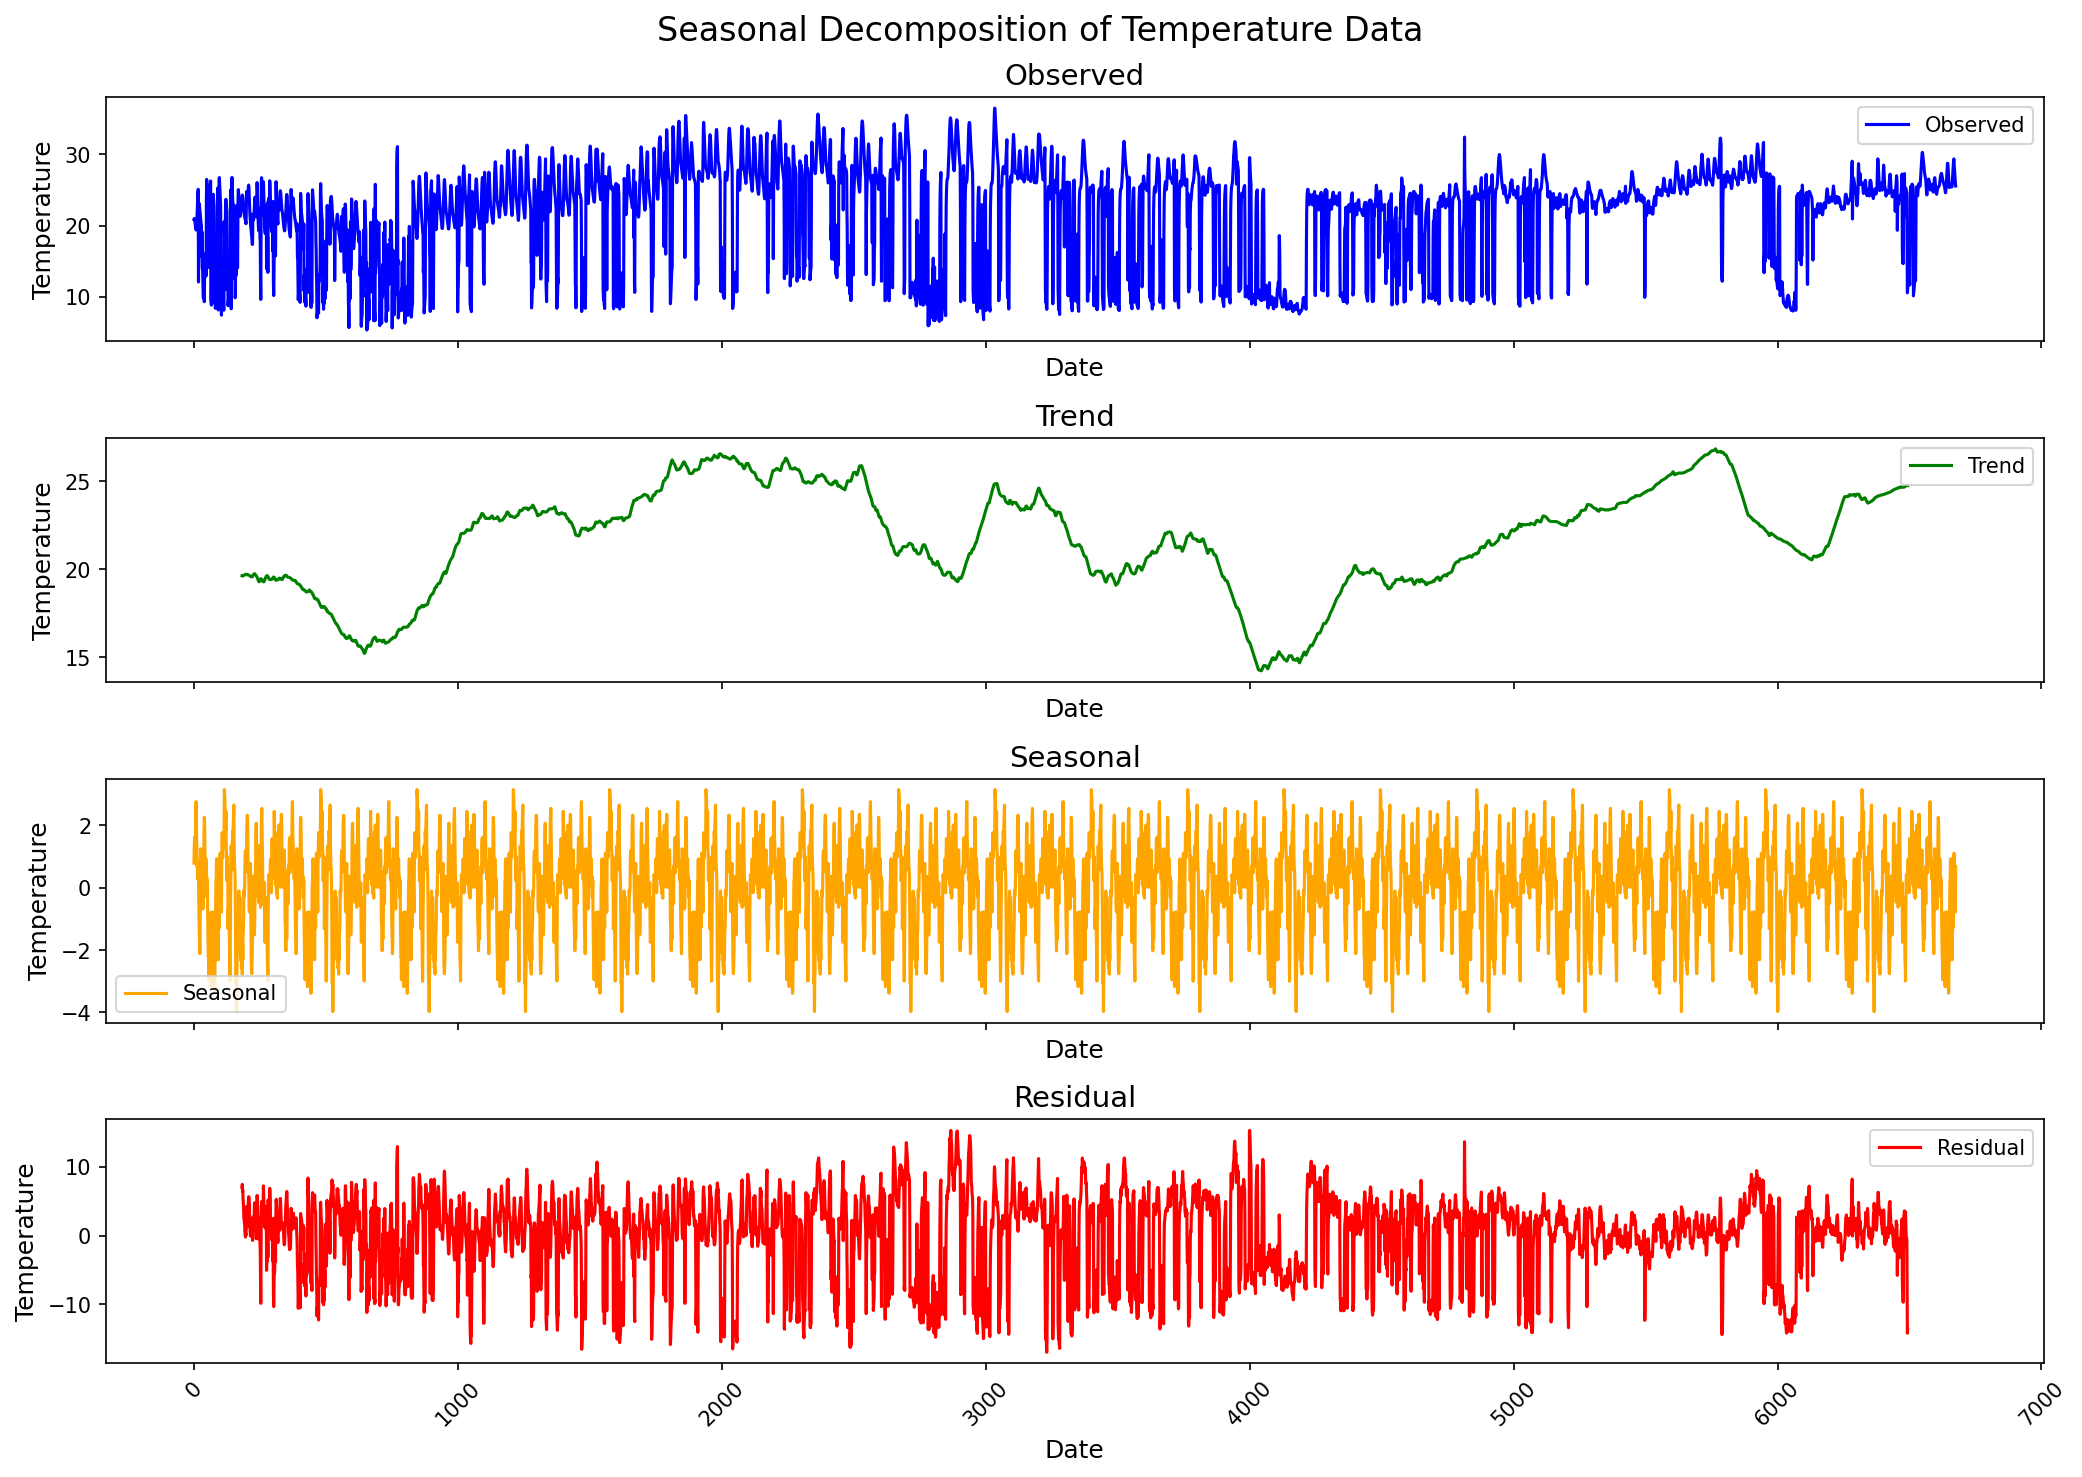

In [28]:
# Seasonal decomposition plot
seasonal_plot = seasonal_decompose(df['DAYTON_MW'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), dpi=150, sharex=True)

# Plot each component
axes[0].plot(seasonal_plot.observed, label='Observed', color='blue')
axes[0].set_title('Observed', fontsize=14)
axes[0].legend(loc='best')

axes[1].plot(seasonal_plot.trend, label='Trend', color='green')
axes[1].set_title('Trend', fontsize=14)
axes[1].legend(loc='best')

axes[2].plot(seasonal_plot.seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal', fontsize=14)
axes[2].legend(loc='best')

axes[3].plot(seasonal_plot.resid, label='Residual', color='red')
axes[3].set_title('Residual', fontsize=14)
axes[3].legend(loc='best')

# Set common labels and rotate x-axis labels
for ax in axes:
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature', fontsize=12)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.suptitle('Seasonal Decomposition of Temperature Data', fontsize=16)
plt.tight_layout()  # Automatically adjust subplot parameters
plt.show()

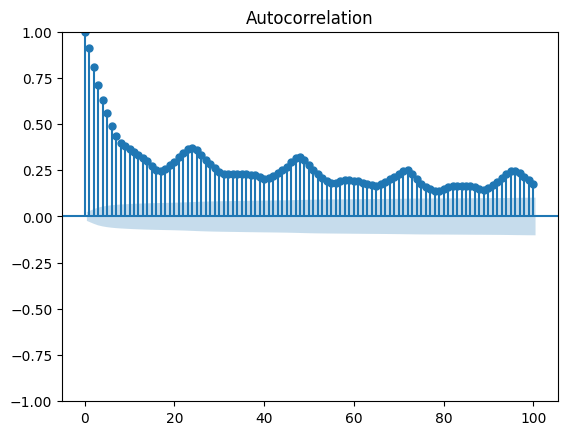

In [34]:
# Plot a autocorrelation plot
plot_acf(df['DAYTON_MW'],lags=100)
plt.show()

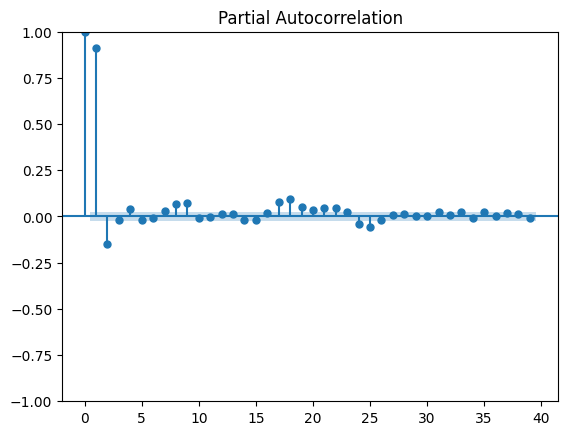

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
series = df['DAYTON_MW']
plot_pacf(series)
plt.show()

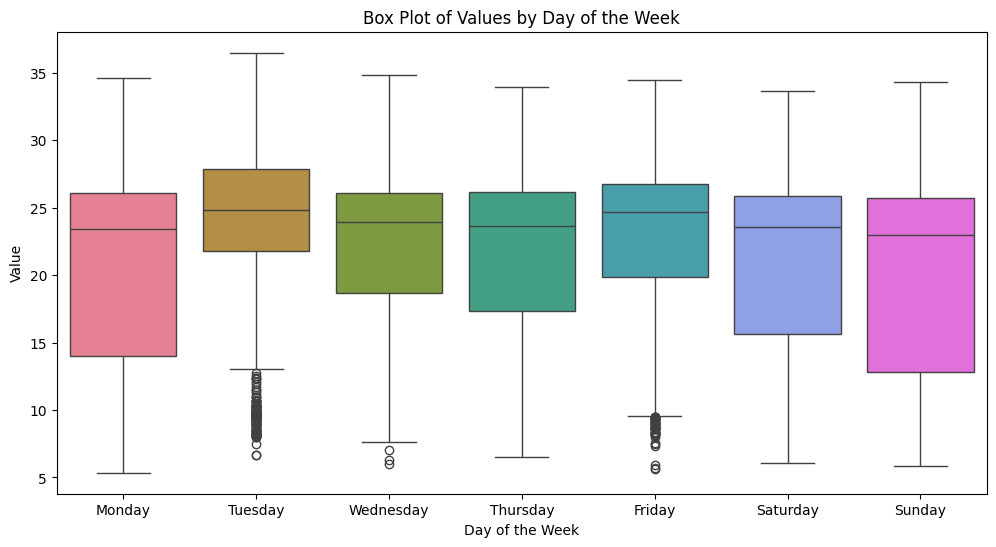

In [32]:
df['day_of_week'] = df['Datetime'].dt.day_name()
df['hour'] = df['Datetime'].dt.hour


# Ensure 'day_of_week' is ordered
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=ordered_days, ordered=True)

palette = sns.color_palette("husl", len(df['day_of_week'].unique()))

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='DAYTON_MW', data=df, palette=palette)
plt.title('Box Plot of Values by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Value')
plt.show()

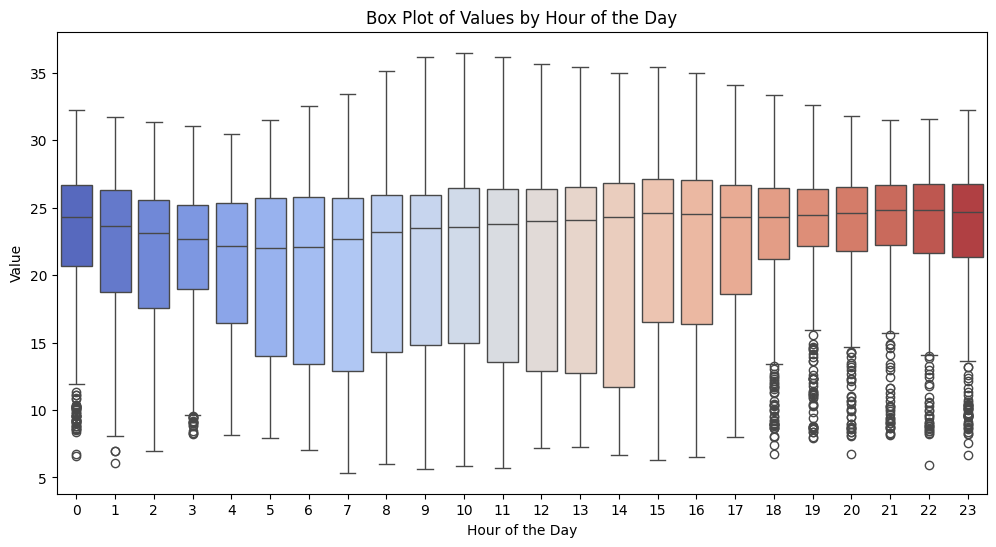

In [33]:
# Plot with seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='DAYTON_MW', data=df, palette='coolwarm')
plt.title('Box Plot of Values by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Value')
plt.xticks(range(24))  # Ensure all hours are displayed
plt.show()

# ARIMA model 

In [37]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_data = df_arima[:train_size]
test_data = df_arima[train_size:]

y_train = train_data['DAYTON_MW']

y_test = test_data['DAYTON_MW']

In [46]:
# Fit the ARIMA(1, 1, 0) model
model = ARIMA(y_train, order=(24, 1, 2))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              DAYTON_MW   No. Observations:                 5340
Model:                ARIMA(24, 1, 2)   Log Likelihood              -13304.543
Date:                Thu, 01 Aug 2024   AIC                          26663.086
Time:                        11:18:34   BIC                          26840.821
Sample:                    01-04-2022   HQIC                         26725.173
                         - 08-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4956      0.242      2.045      0.041       0.020       0.971
ar.L2         -0.5218      0.209     -2.492      0.013      -0.932      -0.111
ar.L3         -0.0871      0.026     -3.370      0.0

In [47]:
# Make predictions on the test set
y_pred = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
#print(y_pred)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R Squared Error: {r2:.5f}')

Mean Absolute Error: 2.86
Root Mean Squared Error: 4.58
R Squared Error: -0.00157


# Prophet Model

In [73]:
split_index = int(len(df_prophet) * 0.8)
train = df_prophet[:split_index]
test = df_prophet[split_index:]

In [74]:
# Initialize the Prophet model
model = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = True)

# Fit the model on the training data
model.fit(train)

11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
# Create a DataFrame with future dates for forecasting
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

In [78]:
len(train),len(test)

(5340, 1336)

In [76]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6671,2026-04-07 11:00:00,45.396167,37.084852,52.855319
6672,2026-04-08 11:00:00,41.954167,34.044478,50.335089
6673,2026-04-09 11:00:00,41.582739,33.929765,49.885962
6674,2026-04-10 11:00:00,42.400092,34.204584,50.048133
6675,2026-04-11 11:00:00,40.451438,32.274087,48.358474


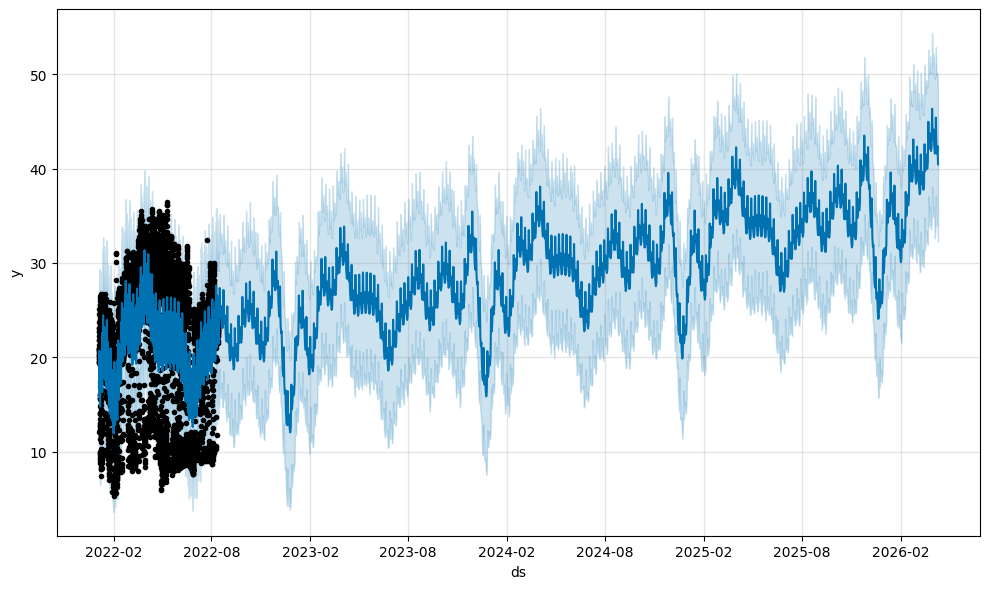

In [79]:
fig1 = m.plot(forecast)


KeyError: 'trend'

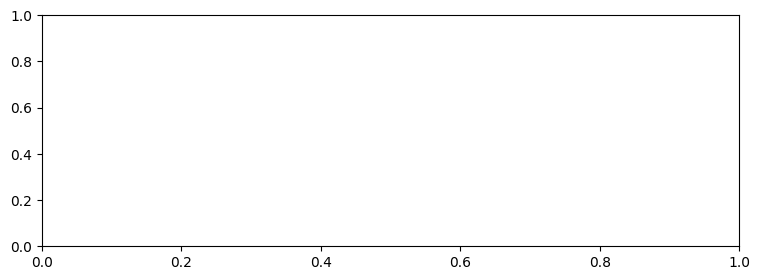

In [80]:
fig2 = m.plot_components(forecast)

In [77]:
# Merge forecast with test data
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
test_forecast = forecast[train.shape[0]:].reset_index(drop=True)
test_df = test.reset_index(drop=True)

# Calculate metrics
mae = mean_absolute_error(test['y'], test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], test_forecast['yhat']))
r2 = r2_score(test['y'], test_forecast['yhat'])

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R Squared Error: {r2:.5f}')

Mean Absolute Error: 7.025370542081935
Root Mean Squared Error: 9.02
R Squared Error: -2.87627


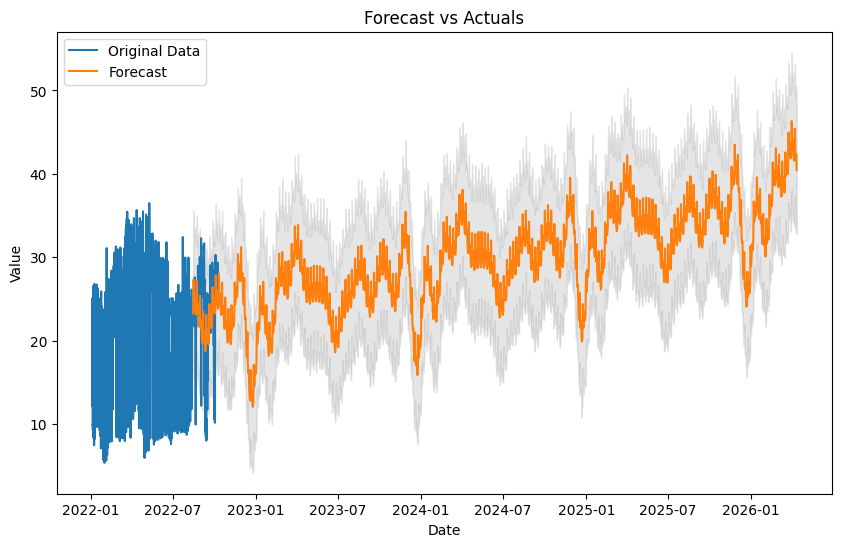

In [71]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Original Data')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Forecast vs Actuals')
plt.show()